In [1]:
import torch
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time

from functools import reduce
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.precision',3)

In [2]:
data_dir = './datasets/Cancer Detection/'
img_dir = data_dir+'labeled images/'
print(os.listdir(data_dir))

['cut images', 'cut images 64', 'cut_images.py', 'labeled images', 'labeled images.zip', 'sample_submission.csv', 'test', 'train_labels.csv']


### Formating the dataset storage
(so it is easier to import using ImageFolder)

In [3]:
# label_file = pd.read_csv(data_dir+'train_labels.csv')
# #print(label_file.head())

# i = 0
# for index, row in label_file.iterrows():
#     os.rename(img_dir+row.id+'.tif',img_dir+str(row.label)+'/'+row.id+'.tif')
    

## Dataset Stuff

### Setting up the dataset tensor

In [4]:
dataset = ImageFolder(img_dir, transform=ToTensor())

In [5]:
img, label = dataset[0]
print(img.shape, label)
print(dataset.classes)
img

torch.Size([3, 96, 96]) 0
['0', '1']


tensor([[[0.9490, 0.9490, 0.9569,  ..., 0.8745, 0.9176, 0.8784],
         [0.9569, 0.9569, 0.9608,  ..., 0.9059, 0.8392, 0.8510],
         [0.9647, 0.9647, 0.9647,  ..., 1.0000, 0.9490, 0.9961],
         ...,
         [0.9255, 0.9686, 0.9569,  ..., 0.9804, 0.9373, 1.0000],
         [0.9922, 0.8863, 0.9569,  ..., 1.0000, 0.9176, 0.9294],
         [0.9529, 0.9451, 0.9961,  ..., 0.6510, 0.8980, 0.8588]],

        [[0.9647, 0.9647, 0.9647,  ..., 0.8275, 0.8745, 0.8353],
         [0.9647, 0.9647, 0.9608,  ..., 0.8667, 0.8000, 0.8118],
         [0.9608, 0.9608, 0.9608,  ..., 0.9647, 0.9255, 0.9725],
         ...,
         [0.9059, 0.9490, 0.9412,  ..., 0.8941, 0.8627, 0.9569],
         [0.9804, 0.8824, 0.9608,  ..., 0.9294, 0.7804, 0.7922],
         [0.9529, 0.9490, 1.0000,  ..., 0.4627, 0.7020, 0.6667]],

        [[0.9608, 0.9608, 0.9608,  ..., 0.8275, 0.8667, 0.8275],
         [0.9529, 0.9529, 0.9529,  ..., 0.8706, 0.7961, 0.8078],
         [0.9451, 0.9451, 0.9451,  ..., 0.9765, 0.9333, 0.

In [6]:
def show_image(img, label):
    print('Label: ', str(label))
    plt.imshow(img.permute(1,2,0))

Label:  0


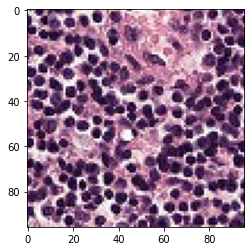

In [7]:
show_image(*dataset[1])

### Train-Validation-Test split

In [8]:
torch.manual_seed(42);
train_size = 50000
val_size = 10000
test_size = 10000
rest_of_dataset_size = len(dataset) - train_size - val_size - test_size

train, val, test, rest_of_dataset = random_split(dataset, [train_size, val_size, test_size, rest_of_dataset_size])
del rest_of_dataset #we're not going to be using this, it was just so random_split works

In [9]:
batch_size = 64
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val, batch_size*2, num_workers=4)

In [10]:
def show_batch(batch):
    for images, _ in  batch:
#         print(images)
        fig, ax = plt.subplots()
        ax.set_xticks([]);
        ax.set_yticks([]);
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break;

In [11]:
#show_batch(train_dl)

## Defining aux functions

In [12]:
def confusion(out, labels):
    tp = tn = fp = fn = 0
    for prob, label in zip(out,labels):
        if prob[0] > prob[1]: pred = 0
        else: pred = 1
        if label==0 and pred==label: tn+=1;
        elif label==0 and pred!=label :fp+=1;
        elif label==1 and pred==label :tp+=1;
        elif label==1 and pred!=label :fn+=1;
    return (tp, tn, fp, fn)

def print_confusion(tp,tn,fp,fn):
    data = {'true_0':{'pred_0':tn, 'pred_1':fp},'true_1':{'pred_0':fn, 'pred_1':tp}}
    return pd.DataFrame(data)

def report(tp,tn,fp,fn):
    precision_1 = tp/max(1,(tp+fp)) #will only divide by 0 if tp is 0 so gives 0 anyway...
    recall_1 = tp/max(1,(tp+fn))    #will only divide by 0 if tp is 0 so gives 0 anyway...
    f1_1 = (2*precision_1*recall_1)/max(0.000001,(precision_1+recall_1)) #will only divide by 0 if the divident is also 0 so...
    precision_0 = tn/max(1,(tn+fn))
    recall_0 = tn/max(1,(tn+fp))
    f1_0 = (2*precision_0*recall_0)/max(0.000001,(precision_0+recall_0))
    data = {'precision':{'0':precision_0, '1':precision_1}, 'recall':{'0':recall_0, '1':recall_1}, 'f1':{'0':f1_0, '1':f1_1}, 'support':{'0':tn+fp,'1':tp+fn}}
    return pd.DataFrame(data)

def history_to_csv(history, filename, train_time):
    with open(filename, 'w') as file:
        file.write('epoch,train_loss,val_loss,accuracy,true_1,true_0,false_1,false_0,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,model_train_time\n')
        for index,ep in enumerate(history):
            rep = report(ep['tp'],ep['tn'],ep['fp'],ep['fn'])
            p0, p1 = rep.precision
            r0, r1 = rep.recall
            f10, f11 = rep.f1
            if index < len(history)-1 :
                file.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(
                    ep['epoch'],ep['train_loss'],ep['val_loss'],ep['val_acc'],ep['tp'],ep['tn'],ep['fp'],ep['fn'],p0,r0,f10,p1,r1,f11))
            else:
                file.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(
                    ep['epoch'],ep['train_loss'],ep['val_loss'],ep['val_acc'],ep['tp'],ep['tn'],ep['fp'],ep['fn'],p0,r0,f10,p1,r1,f11,train_time))

## Into the Convolutions!

### Defining the model

Let's start by defining a _general_ image classification model class that returns the results of training/validating batches of images

In [13]:
def accuracy(outputs, labels):
    """Prints the accuracy"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class myImageClassification(nn.Module):
    def training_step(self, batch):
        """Takes in a batch of training images and returns their loss"""
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        """Takes in a batch of validation images and returns their loss and accuracy"""
        images, labels = batch
        prediction = self(images)
        loss = F.cross_entropy(prediction, labels)
        acc = accuracy(prediction, labels)
        tp, tn, fp, fn = confusion(prediction, labels)
        return {'val_loss': loss.detach(), 'val_acc':acc, 'tp':tp, 'tn':tn, 'fp':fp, 'fn':fn}, prediction #detach so its gradient won't be calculated, so not taking up vram
    
    def validation_epoch_end(self, outputs):
        """Takes in the outputs of the validation step and returns the average loss/accuracy for all batches"""
        batch_losses = [x['val_loss'] for x in outputs] #list of validation losses of each batch
        epoch_loss = torch.stack(batch_losses).mean()   #average validation loss for all the batches 
        batch_accs = [x['val_acc'] for x in outputs]    #list of validation accuracy of each batch
        epoch_acc = torch.stack(batch_accs).mean()      #average validation accuracy for all the batches
        epoch_tp = reduce(lambda a,b: a+b,[x['tp'] for x in outputs])
        epoch_tn = reduce(lambda a,b: a+b,[x['tn'] for x in outputs])
        epoch_fp = reduce(lambda a,b: a+b,[x['fp'] for x in outputs])
        epoch_fn = reduce(lambda a,b: a+b,[x['fn'] for x in outputs])
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item(), 'tp':epoch_tp, 'tn':epoch_tn, 'fp':epoch_fp, 'fn':epoch_fn}
    
    def epoch_end(self, epoch, result, output_file):
        """Prints the result of an epoch"""
        print("\033[94mEpoch [{}]:\033[0m\ntrain_loss: {:.4f}, val_loss: {:.4f} val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        print(print_confusion(result['tp'], result['tn'], result['fp'], result['fn']))
        print(report(result['tp'], result['tn'], result['fp'], result['fn']),'\n')
        if(output_file != None) :
            with open(output_file, 'a') as file:
                file.write("Epoch [{}]:\ntrain_loss: {:.4f}, val_loss: {:.4f} val_acc: {:.4f}\n".format(
                            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
                file.write(print_confusion(result['tp'], result['tn'], result['fp'], result['fn']).to_string()+'\n')
                file.write(report(result['tp'], result['tn'], result['fp'], result['fn']).to_string()+'\n\n\n')
                
        

Now we can define our model's architecture, this is what this whole project revolves around and what we will be modifying and studying.

In [14]:
class PCamModel(myImageClassification):
    def __init__(self):
        """Define the model's network architecture"""
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,8,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(8,16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),            
            nn.Conv2d(128,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,32,kernel_size=3,padding=1),
            nn.ReLU(),            
            nn.Conv2d(32,16,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(16,8,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(8*12*12, 2),
            nn.Softmax(dim=1),
#             nn.ReLU(),
#             nn.Linear(2048, 256),
#             nn.ReLU(),
#             nn.Linear(256,2)       
        )
        
    def forward(self, xb):
        """Apply the network to the batch of 'x'(images)"""
        return self.network(xb)
      

### Setting up for training

In [15]:
model = PCamModel()
model

PCamModel(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), pa

Now we define a some functions/class to send our model and dataloaders (batch generators) to a device so that we can make use of a GPU

In [16]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap dataloader to put it onto a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for batch in self.dl:
            yield to_device(batch, self.device)
            
    def __len__(self):
        """Returns the number of batches in the dataloader"""
        return len(self.dl)

Having done this, we can send our model and the train/validation dataloaders to the _CUDA_ device (a grafics card)

In [17]:
myGPU = torch.device('cuda')
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, myGPU)
val_dl = DeviceDataLoader(val_dl, myGPU)
to_device(model, myGPU);

In [18]:
for images, labels in train_dl:
    print('Image shape', images.shape)
    out = model(images)
    print('Output shape', out.shape)
    print('First output', out[0])
    break

Image shape torch.Size([64, 3, 96, 96])
Output shape torch.Size([64, 2])
First output tensor([0.4977, 0.5023], device='cuda:0', grad_fn=<SelectBackward0>)


Now we define the evaluation and fit functions to use our model on. When fitting/training our model we can pick number of epochs, an optimization function, wether to use early stopping or not and the patience of early stopping. After training all epochs, the one with the best validation accuracy is kept as the final model.

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    history = []
    outputs = []
    for batch in val_loader: 
        hist, pred = model.validation_step(batch)
        history.append(hist)
        outputs+= pred.cpu().detach().numpy().tolist()
    prediction = []
    for w0,w1 in outputs:
        prediction.append(w1)
    return (model.validation_epoch_end(history), prediction)

def fit(epochs, lr, model, train_loader, val_loader,opt_func=torch.optim.SGD, early_stopping=False, patience=5, output_file=None):
    remaining_patience = patience
    best_acc = 0
    best_epoch = 0
    optimizer = opt_func(model.parameters(), lr)
    history=[]
    for epoch in range(epochs):
        #Training phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss.detach())
            loss.backward()           #calculate the gradient
            optimizer.step()          #use it for gradient descent
            optimizer.zero_grad()     #resets gradients/derivatives
        #Validation phase
        result, _ = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['epoch']=epoch
        model.epoch_end(epoch, result, output_file)
        history.append(result)
        if result['val_acc'] > best_acc:
            best_acc = result['val_acc']
            best_epoch = epoch
            remaining_patience=patience
            torch.save(model.state_dict(), 'current_model_best_accuracy.pth')
        else: remaining_patience-=1
        if early_stopping and remaining_patience==0: break
    model.load_state_dict(torch.load('current_model_best_accuracy.pth'))
    result, _ = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['epoch'] = best_epoch
    model.epoch_end(str(best_epoch)+'(final model)', result, output_file)
    history.append(result)
    return history


We test that everything works correctly:

In [20]:
model = to_device(PCamModel(), myGPU)

In [21]:
ev,_ = evaluate(model, val_dl) #results without training
print(ev)

{'val_loss': 0.6896322965621948, 'val_acc': 0.5998813509941101, 'tp': 0, 'tn': 5982, 'fp': 0, 'fn': 4018}


### Training the model

The following function trains the models specified by its arguments. It was designed when I was using architectures that increased in size by one layer at a time, hence the use of start_size and end_size and a for loop iterating through the sizes. In the end I settled on 3 different architecture sizes in terms of layers, so this feature isn't really used.

The function automatically saves all results in various files (the training history in a csv file along with the training histories of all other models, the training history+test results of the fully trained model in its own txt file, and these same test results again in another csv file with all the other models' results)

In [22]:
def train_model(model_group,model_id,name_modifier='',start_size=1,end_size=9,model_modifier=''):
    num_epochs = 30
    learning_rate = 0.0005
    opt_func = torch.optim.Adam
    for i in range(start_size,end_size+1):
        model_name = model_group+'-'+model_id+'-'+str(i)+model_modifier
        output_name = model_name+name_modifier
        print('Training '+output_name+':\n')
        model = to_device(torch.load('./Models/'+model_group+'/'+model_name+'.pth'), myGPU)
        result_file = './Results/'+model_group+'/'+output_name+'.txt'
        #clear the file before storing the results
        with open(result_file,'w') as file:
            file.write('Optimizer: '+str(opt_func)+'\n')
            file.write('Train size: {}, Validation size: {}, Test size: {}, Batch size: {}\nLearning Rate: {}\n\n'.format(train_size,val_size,test_size,batch_size,learning_rate))
        #TRAIN
        start_time = time.time()
        history = fit(num_epochs, learning_rate, model, train_dl, val_dl, opt_func, output_file=result_file)
        end_time = time.time()
        train_time = end_time-start_time
        print('\033[93mTraining time: '+str(train_time)+'s\033[0m\n')

        #STORE THE HISTORY INTO A CSV FILE
        history_to_csv(history, './Results/history CSVs/'+output_name+'.csv', train_time)

        #STORE THE TEST RESULTS OF THE FINAL MODEL
        test_dl = DeviceDataLoader(DataLoader(test, batch_size*2), myGPU)
        result, predicted_labels = evaluate(model, test_dl)
        y_test = []
        for _,labels in test_dl:
            y_test+=labels.cpu().detach().tolist()
        auc_score = roc_auc_score(y_test,predicted_labels)
        rep = report(result['tp'], result['tn'], result['fp'], result['fn'])
        with open(result_file, 'a') as file:
            file.write('Total training time: '+str(train_time)+'s ('+str((train_time)/60)+'min)\n\n')
            file.write('TEST RESULTS OF THE MODEL (the epoch with best accuracy is kept as the model):\n')
            file.write(print_confusion(result['tp'], result['tn'], result['fp'], result['fn']).to_string()+'\n')
            file.write(rep.to_string()+'\n\n')
            file.write('These results are of the test partition, not validation:\n'+str(result)+'\n')
            file.write('Area Under the Receiver Operative Characteristic Curve (ROC AUC): '+str(auc_score))

        with open('./Results/Test Results/results.csv', 'a') as file:
            #model_name,accuracy,auc_score,true_0,true_1,false_0,false_1,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,train_time
            file.write('{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n'
                       .format(output_name,result['val_acc'],auc_score,result['tn'],result['tp'],result['fn'],result['fp']
                               ,rep['precision'][0],rep['precision'][1],rep['recall'][0],rep['recall'][1],rep['f1'][0],rep['f1'][1],train_time))

        #SAVE THE TRAINED MODEL
        torch.save(model, './Trained Models/'+model_group+'/'+output_name+'.pth')
    return model, history

These are some examples of how to train some architectures/models. In this case, two 3 layer architectures in the up desing with 128 and 256 total feature maps respectively, each trained 3 times into 3 different final models:

In [199]:
model0, history0 = train_model('up','128','_1',3,3)
model0, history0 = train_model('up','128','_2',3,3)
model0, history0 = train_model('up','128','_3',3,3)

model0, history0 = train_model('up','256','_1',3,3)
model0, history0 = train_model('up','256','_2',3,3)
model0, history0 = train_model('up','256','_3',3,3)

Training up-128-3:

Epoch [0]:
train_loss: 0.5285, val_loss: 0.5007 val_acc: 0.8021
        true_0  true_1
pred_0    4979     991
pred_1    1003    3027
   precision  recall     f1  support
0      0.834   0.832  0.833     5982
1      0.751   0.753  0.752     4018 

Epoch [1]:
train_loss: 0.5060, val_loss: 0.4904 val_acc: 0.8117
        true_0  true_1
pred_0    5227    1135
pred_1     755    2883
   precision  recall     f1  support
0      0.822   0.874  0.847     5982
1      0.792   0.718  0.753     4018 

Epoch [2]:
train_loss: 0.4913, val_loss: 0.4811 val_acc: 0.8242
        true_0  true_1
pred_0    4887     676
pred_1    1095    3342
   precision  recall     f1  support
0      0.878   0.817  0.847     5982
1      0.753   0.832  0.791     4018 

Epoch [3]:
train_loss: 0.4792, val_loss: 0.4883 val_acc: 0.8150
        true_0  true_1
pred_0    5692    1567
pred_1     290    2451
   precision  recall     f1  support
0      0.784   0.952  0.860     5982
1      0.894   0.610  0.725     401

Epoch [11]:
train_loss: 0.4352, val_loss: 0.4545 val_acc: 0.8517
        true_0  true_1
pred_0    5714    1218
pred_1     268    2800
   precision  recall     f1  support
0      0.824   0.955  0.885     5982
1      0.913   0.697  0.790     4018 

Epoch [12]:
train_loss: 0.4278, val_loss: 0.4385 val_acc: 0.8717
        true_0  true_1
pred_0    5388     696
pred_1     594    3322
   precision  recall     f1  support
0      0.886   0.901  0.893     5982
1      0.848   0.827  0.837     4018 

Epoch [13]:
train_loss: 0.4253, val_loss: 0.4342 val_acc: 0.8743
        true_0  true_1
pred_0    5417     699
pred_1     565    3319
   precision  recall     f1  support
0      0.886   0.906  0.896     5982
1      0.855   0.826  0.840     4018 

Epoch [14]:
train_loss: 0.4188, val_loss: 0.4366 val_acc: 0.8715
        true_0  true_1
pred_0    5500     810
pred_1     482    3208
   precision  recall     f1  support
0      0.872   0.919  0.895     5982
1      0.869   0.798  0.832     4018 

Epoch [15]:


Epoch [1]:
train_loss: 0.4970, val_loss: 0.4672 val_acc: 0.8410
        true_0  true_1
pred_0    5466    1078
pred_1     516    2940
   precision  recall     f1  support
0      0.835   0.914  0.873     5982
1      0.851   0.732  0.787     4018 

Epoch [2]:
train_loss: 0.4772, val_loss: 0.4591 val_acc: 0.8496
        true_0  true_1
pred_0    5493    1018
pred_1     489    3000
   precision  recall     f1  support
0      0.844   0.918  0.879     5982
1      0.860   0.747  0.799     4018 

Epoch [3]:
train_loss: 0.4654, val_loss: 0.4503 val_acc: 0.8585
        true_0  true_1
pred_0    5559    1001
pred_1     423    3017
   precision  recall     f1  support
0      0.847   0.929  0.886     5982
1      0.877   0.751  0.809     4018 

Epoch [4]:
train_loss: 0.4537, val_loss: 0.4419 val_acc: 0.8666
        true_0  true_1
pred_0    5541     901
pred_1     441    3117
   precision  recall     f1  support
0      0.860   0.926  0.892     5982
1      0.876   0.776  0.823     4018 

Epoch [5]:
train

Epoch [12]:
train_loss: 0.4051, val_loss: 0.4294 val_acc: 0.8794
        true_0  true_1
pred_0    5383     621
pred_1     599    3397
   precision  recall     f1  support
0      0.897   0.900  0.898     5982
1      0.850   0.845  0.848     4018 

Epoch [13]:
train_loss: 0.3998, val_loss: 0.4485 val_acc: 0.8612
        true_0  true_1
pred_0    5067     482
pred_1     915    3536
   precision  recall     f1  support
0      0.913   0.847  0.879     5982
1      0.794   0.880  0.835     4018 

Epoch [14]:
train_loss: 0.3925, val_loss: 0.4271 val_acc: 0.8821
        true_0  true_1
pred_0    5553     763
pred_1     429    3255
   precision  recall     f1  support
0      0.879   0.928  0.903     5982
1      0.884   0.810  0.845     4018 

Epoch [15]:
train_loss: 0.3871, val_loss: 0.4321 val_acc: 0.8777
        true_0  true_1
pred_0    5475     730
pred_1     507    3288
   precision  recall     f1  support
0      0.882   0.915  0.898     5982
1      0.866   0.818  0.842     4018 

Epoch [16]:


This next cell takes 20 mins to run but does nothing, if placed before a training block of code you can delay its start, so it's a countdown/timer of sorts. You might ask, why is this useful? well, when I wanted to train models at night, I used this to give myself 20 mins to fall asleep before the laptop fans got super loud because of training.

In [30]:
time.sleep(1200)

Some more examples of training, this time with different naming conventions that could be used, these are some that I used early into development to find a good base architecture.

In [67]:
model, history = train_model('up','256','_64',9,9,'-3max')
model, history = train_model('up','256','_64',9,9,'-2max')

Training up-256-9-3max:

Epoch [0]:
train_loss: 0.5819, val_loss: 0.5210 val_acc: 0.7822
        true_0  true_1
pred_0    4886    1099
pred_1    1096    2919
   precision  recall     f1  support
0      0.816   0.817  0.817     5982
1      0.727   0.726  0.727     4018 

Epoch [1]:
train_loss: 0.5261, val_loss: 0.5195 val_acc: 0.7829
        true_0  true_1
pred_0    4764     970
pred_1    1218    3048
   precision  recall     f1  support
0      0.831   0.796  0.813     5982
1      0.714   0.759  0.736     4018 

Epoch [2]:
train_loss: 0.5220, val_loss: 0.5118 val_acc: 0.7921
        true_0  true_1
pred_0    4989    1102
pred_1     993    2916
   precision  recall     f1  support
0      0.819   0.834  0.826     5982
1      0.746   0.726  0.736     4018 

Epoch [3]:
train_loss: 0.5180, val_loss: 0.5109 val_acc: 0.7917
        true_0  true_1
pred_0    5215    1325
pred_1     767    2693
   precision  recall     f1  support
0      0.797   0.872  0.833     5982
1      0.778   0.670  0.720   

Epoch [11]:
train_loss: 0.5034, val_loss: 0.5010 val_acc: 0.8029
        true_0  true_1
pred_0    4812     809
pred_1    1170    3209
   precision  recall     f1  support
0      0.856   0.804  0.829     5982
1      0.733   0.799  0.764     4018 

Epoch [12]:
train_loss: 0.5014, val_loss: 0.5039 val_acc: 0.8002
        true_0  true_1
pred_0    4709     733
pred_1    1273    3285
   precision  recall     f1  support
0      0.865   0.787  0.824     5982
1      0.721   0.818  0.766     4018 

Epoch [13]:
train_loss: 0.5007, val_loss: 0.4949 val_acc: 0.8082
        true_0  true_1
pred_0    5132    1075
pred_1     850    2943
   precision  recall     f1  support
0      0.827   0.858  0.842     5982
1      0.776   0.732  0.754     4018 

Epoch [14]:
train_loss: 0.4998, val_loss: 0.4970 val_acc: 0.8068
        true_0  true_1
pred_0    4989     947
pred_1     993    3071
   precision  recall     f1  support
0      0.840   0.834  0.837     5982
1      0.756   0.764  0.760     4018 

Epoch [15]:


In [153]:
model, history = train_model('up','256','_64',9,9,'-3maxpad')
model, history = train_model('up','256','_64',9,9,'-2maxpad')

Training up-256-9-3maxpad:

Epoch [0]:
train_loss: 0.5496, val_loss: 0.5055 val_acc: 0.7968
        true_0  true_1
pred_0    5059    1125
pred_1     923    2893
   precision  recall     f1  support
0      0.818   0.846  0.832     5982
1      0.758   0.720  0.739     4018 

Epoch [1]:
train_loss: 0.5143, val_loss: 0.5020 val_acc: 0.8048
        true_0  true_1
pred_0    4840     825
pred_1    1142    3193
   precision  recall     f1  support
0      0.854   0.809  0.831     5982
1      0.737   0.795  0.765     4018 

Epoch [2]:
train_loss: 0.4969, val_loss: 0.4821 val_acc: 0.8232
        true_0  true_1
pred_0    5316    1094
pred_1     666    2924
   precision  recall     f1  support
0      0.829   0.889  0.858     5982
1      0.814   0.728  0.769     4018 

Epoch [3]:
train_loss: 0.4872, val_loss: 0.4656 val_acc: 0.8429
        true_0  true_1
pred_0    5286     865
pred_1     696    3153
   precision  recall     f1  support
0      0.859   0.884  0.871     5982
1      0.819   0.785  0.802

Epoch [11]:
train_loss: 0.4610, val_loss: 0.4643 val_acc: 0.8408
        true_0  true_1
pred_0    5629    1236
pred_1     353    2782
   precision  recall     f1  support
0      0.820   0.941  0.876     5982
1      0.887   0.692  0.778     4018 

Epoch [12]:
train_loss: 0.4599, val_loss: 0.4541 val_acc: 0.8523
        true_0  true_1
pred_0    5202     686
pred_1     780    3332
   precision  recall     f1  support
0      0.883   0.870  0.876     5982
1      0.810   0.829  0.820     4018 

Epoch [13]:
train_loss: 0.4565, val_loss: 0.4467 val_acc: 0.8602
        true_0  true_1
pred_0    5362     780
pred_1     620    3238
   precision  recall     f1  support
0      0.873   0.896  0.885     5982
1      0.839   0.806  0.822     4018 

Epoch [14]:
train_loss: 0.4540, val_loss: 0.4622 val_acc: 0.8431
        true_0  true_1
pred_0    5647    1238
pred_1     335    2780
   precision  recall     f1  support
0      0.820   0.944  0.878     5982
1      0.892   0.692  0.779     4018 

Epoch [15]:


In [102]:
model, history = train_model('up','256','_64',9,9,'-3maxpad48')
model, history = train_model('up','256','_64',9,9,'-2maxpad48')

Training up-256-9-3maxpad48:

Epoch [0]:
train_loss: 0.5671, val_loss: 0.5235 val_acc: 0.7805
        true_0  true_1
pred_0    4763     973
pred_1    1219    3045
   precision  recall     f1  support
0      0.830   0.796  0.813     5982
1      0.714   0.758  0.735     4018 

Epoch [1]:
train_loss: 0.5248, val_loss: 0.5264 val_acc: 0.7762
        true_0  true_1
pred_0    5379    1632
pred_1     603    2386
   precision  recall     f1  support
0      0.767   0.899  0.828     5982
1      0.798   0.594  0.681     4018 

Epoch [2]:
train_loss: 0.5158, val_loss: 0.5049 val_acc: 0.7970
        true_0  true_1
pred_0    5291    1334
pred_1     691    2684
   precision  recall     f1  support
0      0.799   0.884  0.839     5982
1      0.795   0.668  0.726     4018 

Epoch [3]:
train_loss: 0.5093, val_loss: 0.4921 val_acc: 0.8108
        true_0  true_1
pred_0    5379    1282
pred_1     603    2736
   precision  recall     f1  support
0      0.808   0.899  0.851     5982
1      0.819   0.681  0.7

Epoch [11]:
train_loss: 0.4803, val_loss: 0.4757 val_acc: 0.8297
        true_0  true_1
pred_0    5430    1135
pred_1     552    2883
   precision  recall     f1  support
0      0.827   0.908  0.866     5982
1      0.839   0.718  0.774     4018 

Epoch [12]:
train_loss: 0.4785, val_loss: 0.4687 val_acc: 0.8377
        true_0  true_1
pred_0    5341     972
pred_1     641    3046
   precision  recall     f1  support
0      0.846   0.893  0.869     5982
1      0.826   0.758  0.791     4018 

Epoch [13]:
train_loss: 0.4769, val_loss: 0.4719 val_acc: 0.8348
        true_0  true_1
pred_0    5375    1036
pred_1     607    2982
   precision  recall     f1  support
0      0.838   0.899  0.867     5982
1      0.831   0.742  0.784     4018 

Epoch [14]:
train_loss: 0.4754, val_loss: 0.4904 val_acc: 0.8128
        true_0  true_1
pred_0    5634    1524
pred_1     348    2494
   precision  recall     f1  support
0      0.787   0.942  0.858     5982
1      0.878   0.621  0.727     4018 

Epoch [15]:


In [176]:
model, history = train_model('up','256','_64',9,9,'-3maxpad64')
model, history = train_model('up','256','_64',9,9,'-2maxpad64')

Training up-256-9-3maxpad64:

Epoch [0]:
train_loss: 0.5517, val_loss: 0.5159 val_acc: 0.7861
        true_0  true_1
pred_0    5139    1306
pred_1     843    2712
   precision  recall     f1  support
0      0.797   0.859  0.827     5982
1      0.763   0.675  0.716     4018 

Epoch [1]:
train_loss: 0.5220, val_loss: 0.5116 val_acc: 0.7950
        true_0  true_1
pred_0    4971    1048
pred_1    1011    2970
   precision  recall     f1  support
0      0.826   0.831  0.828     5982
1      0.746   0.739  0.743     4018 

Epoch [2]:
train_loss: 0.5120, val_loss: 0.4975 val_acc: 0.8079
        true_0  true_1
pred_0    4995     942
pred_1     987    3076
   precision  recall     f1  support
0      0.841   0.835  0.838     5982
1      0.757   0.766  0.761     4018 

Epoch [3]:
train_loss: 0.4989, val_loss: 0.5008 val_acc: 0.8047
        true_0  true_1
pred_0    4757     722
pred_1    1225    3296
   precision  recall     f1  support
0      0.868   0.795  0.830     5982
1      0.729   0.820  0.7

Epoch [11]:
train_loss: 0.4699, val_loss: 0.4779 val_acc: 0.8259
        true_0  true_1
pred_0    4938     695
pred_1    1044    3323
   precision  recall     f1  support
0      0.877   0.825  0.850     5982
1      0.761   0.827  0.793     4018 

Epoch [12]:
train_loss: 0.4675, val_loss: 0.4706 val_acc: 0.8370
        true_0  true_1
pred_0    5331     976
pred_1     651    3042
   precision  recall     f1  support
0      0.845   0.891  0.868     5982
1      0.824   0.757  0.789     4018 

Epoch [13]:
train_loss: 0.4657, val_loss: 0.5003 val_acc: 0.8047
        true_0  true_1
pred_0    4674     639
pred_1    1308    3379
   precision  recall     f1  support
0      0.880   0.781  0.828     5982
1      0.721   0.841  0.776     4018 

Epoch [14]:
train_loss: 0.4639, val_loss: 0.4660 val_acc: 0.8394
        true_0  true_1
pred_0    5221     842
pred_1     761    3176
   precision  recall     f1  support
0      0.861   0.873  0.867     5982
1      0.807   0.790  0.798     4018 

Epoch [15]:


### Analysing the results

This section is left from the begining of the project, when I trained, tested and analyzed the result of individual architectures in the same notebook. This was useful when starting to look for what makes a good architecture, what are some good training hyperparameters and also how CNNs work in general.

This ended up being replaced by the *Graph Generation* notebook and the *Defining aux functions* section of this one as well as some other code spread across other functions like the ones that print results in text/csv files. 

This being said, some parts of this section were still useful later on for analysis of specific models, for example the generation of ROCs.

In [ ]:
def plot_accuracies(history):
    model_epoch = history[-1]['epoch']
    accuracies = [epoch['val_acc'] for epoch in history[:-1]]
    
    plt.axvline(model_epoch, color='green', linewidth=1)
    plt.plot(accuracies, '-x')
    plt.grid(True, axis='y')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Selected Epoch'])
    plt.title('Accuracy per epoch')
    
def plot_losses(history):
    model_epoch = history[-1]['epoch']
    train_losses = [x['train_loss'] for x in history[:-1]]
    val_losses = [x['val_loss'] for x in history[:-1]]
    
    min_val_loss = min(val_losses)
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.axvline(model_epoch, color='green', linewidth=1)
    plt.axhline(min_val_loss, color='orange', linewidth=1)
    plt.grid(True, axis='y')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation', 'Selected Epoch', 'Min. Validation Loss'])
    plt.title('Loss per epoch')

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
def pred_image(img, model):
    xb = to_device(img.unsqueeze(0), myGPU)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    print(yb)
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test[34]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', pred_image(img, model))

The cells below are for analyzing a specific saved model.

In [18]:
model_group = 'valley'
model_name = model_group+'-256-6_1'
model = to_device(torch.load('./Trained Models/Increase Epochs/'+model_group+'/'+model_name+'.pth'), myGPU)

In [21]:
test_dl = DeviceDataLoader(DataLoader(test, batch_size*2), myGPU)
result, pred_labels = evaluate(model, test_dl)
print_confusion(result['tp'], result['tn'], result['fp'], result['fn'])
report(result['tp'], result['tn'], result['fp'], result['fn'])
print('These results are of the test partition, not validation:\n',result)

,true_0,true_1
pred_0,5652,685
pred_1,287,3376


,precision,recall,f1,support
0,0.892,0.952,0.921,5939
1,0.922,0.831,0.874,4061


These results are of the test partition, not validation:
 {'val_loss': 0.4085288345813751, 'val_acc': 0.9017998576164246, 'tp': 3376, 'tn': 5652, 'fp': 287, 'fn': 685}


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC of model valley-256-6_1')

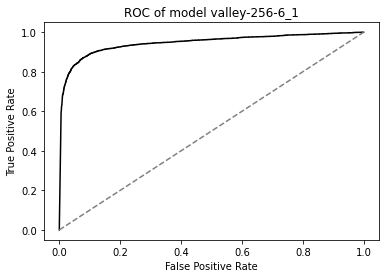

0.9459292680045702


In [32]:
# y_test = []
# for _,labels in test_dl:
#     y_test+=labels.cpu().detach().tolist()
# fpr, tpr, thresholds = roc_curve(y_test, pred_labels)
# optimal_index = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_index]
# print('Optimal threshold: ',optimal_threshold)

plt.plot(fpr, tpr, color='black')
# plt.scatter(fpr[optimal_index], tpr[optimal_index], marker='o', color='black', label='"Best"')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of model valley-256-6_1')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.savefig('./Images/ROC-valley-256-6_1.png')
plt.show()

auc_score = roc_auc_score(y_test,pred_labels)
print(auc_score)